In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
mu = 3
sigma = 2
values_distr =stats.logistic(loc=mu, scale=sigma)

def gen_data(values = values_distr, num_true = 4):
    nobs = 1000
    
    #parameters
    
    
    min_bids =num_true
    max_bids =num_true
    
    bid_types = range(min_bids,max_bids+1)
    prob_type = [1/len(bid_types)]*len(bid_types)
    bidders = np.random.choice(bid_types, nobs, p=prob_type)
    bidders = np.sort(bidders)
    bids = []
    for i in bid_types:
        #count number of obs
        num_i = sum(i == bidders)
        bids_i = values.rvs(size=(num_i,i))
        bids_i =  np.sort(bids_i, axis=1)
        bids_i =  bids_i[:,-2]
        bids = np.concatenate((bids, bids_i))
    
    #draw bids
    return bids, np.ones(nobs), nobs



bids,xn,nobs = gen_data(values_distr)

In [9]:
class Auction(GenericLikelihoodModel):
    
    def __init__(self, *args, values_distr=stats.logistic, **kwargs):
        super(Auction,self).__init__(*args,**kwargs)
        self.values_distr = values_distr
        
    
    def loglikeobs(self, params):
        bids = self.endog
        i = self.exog[:,0]
        cdf = self.values_distr.cdf(bids,loc=params[0],scale=max(params[1],1e-5))
        pdf = self.values_distr.pdf(bids,loc=params[0],scale=max(params[1],1e-5))
        factorial = scipy.special.factorial(i)/scipy.special.factorial(i-2)  
        
        order_cdf = factorial*pdf*cdf**(i-2)*(1-cdf) #np.log(i) + np.log(cdf) + (i-1)*np.log((1-cdf)) #second highest order statistic
        return np.log(order_cdf)
    

np.random.seed()
yn,xn,nobs = gen_data(stats.logistic(loc=mu, scale=sigma))
model = Auction(yn, np.ones(len(yn))*4 )
model_fit = model.fit(start_params=[mu,sigma],disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Auction Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -2074.2
Model:                        Auction   AIC:                             4150.
Method:            Maximum Likelihood   BIC:                             4155.
Date:                Thu, 31 Dec 2020                                         
Time:                        15:32:47                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1171      0.062     50.146      0.000       2.995       3.239
par0           1.9016      0.046     40.962      0.000       1.811       1.993
==============================================================================
"""

In [26]:
def setup_shi(yn,xn, num_bidders1 = 10, num_bidders2 = 2):
    model1 = Auction(yn,np.ones(len(yn))*num_bidders1)
    model1_fit = model1.fit(start_params=[mu,sigma],disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    
    #fit logistic values
    model2 = Auction(yn,np.ones(len(yn))*num_bidders2)
    model2_fit = model2.fit(start_params=[mu,sigma],disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    print("mu1:%.3f sigma1:%.3f // mu2:%.3f sigma2:%.3f"%(
        tuple(np.concatenate([model1_fit.params,model2_fit.params] )) ))
    return ll1,grad1,hess1,ll2,2, grad2,hess2,2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn, num_bidders1 = 10, num_bidders2 = 2)

mu1:-0.040 sigma1:2.428 // mu2:5.403 sigma2:1.410


mu1:-0.081 sigma1:2.413 // mu2:5.331 sigma2:1.388
mu1:-0.158 sigma1:2.398 // mu2:5.250 sigma2:1.437
mu1:-0.277 sigma1:2.514 // mu2:5.395 sigma2:1.504
mu1:-0.108 sigma1:2.423 // mu2:5.338 sigma2:1.409
mu1:-0.247 sigma1:2.490 // mu2:5.333 sigma2:1.463
mu1:-0.018 sigma1:2.339 // mu2:5.262 sigma2:1.390
mu1:-0.079 sigma1:2.364 // mu2:5.253 sigma2:1.420
mu1:-0.170 sigma1:2.418 // mu2:5.272 sigma2:1.430
mu1:-0.207 sigma1:2.459 // mu2:5.330 sigma2:1.430
mu1:-0.096 sigma1:2.409 // mu2:5.352 sigma2:1.450
-----
mu1:0.033 sigma1:2.299 // mu2:5.216 sigma2:1.369
mu1:0.024 sigma1:2.352 // mu2:5.370 sigma2:1.429
mu1:0.055 sigma1:2.342 // mu2:5.373 sigma2:1.420
mu1:0.062 sigma1:2.330 // mu2:5.331 sigma2:1.401
mu1:0.181 sigma1:2.236 // mu2:5.259 sigma2:1.355
mu1:0.068 sigma1:2.309 // mu2:5.321 sigma2:1.400
mu1:0.013 sigma1:2.297 // mu2:5.222 sigma2:1.400
mu1:-0.132 sigma1:2.346 // mu2:5.164 sigma2:1.389
mu1:0.042 sigma1:2.335 // mu2:5.313 sigma2:1.387
mu1:-0.062 sigma1:2.381 // mu2:5.333 sigma2:1.430


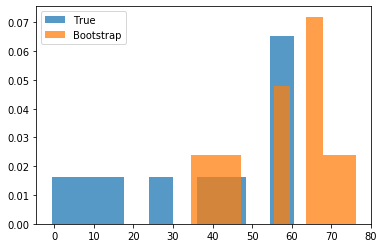

In [30]:
true_stats = vuong_plots.plot_true(gen_data,setup_shi)
yn,xn,nobs = gen_data()
print('-----')
bootstrap_stats = vuong_plots.plot_bootstrap(yn,xn,nobs,setup_shi)

#anayltic_stats = vuong_plots.plot_analytic(yn,xn,nobs,setup_shi)
plt.legend()
plt.show()

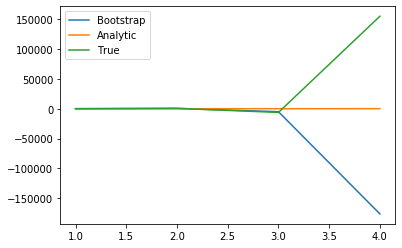

In [6]:
plt.plot(range(1,5),  [ stats.kstat(bootstrap_stats,n=i) for i in range(1,5)], label="Bootstrap")
plt.plot(range(1,5),  [ stats.kstat(anayltic_stats,n=i) for i in range(1,5)], label="Analytic")
plt.plot(range(1,5),  [ stats.kstat(true_stats,n=i) for i in range(1,5)], label="True")

plt.legend()